In [1]:
# %load_ext autoreload
# %autoreload 2
# %matplotlib notebook

import numpy as np
import pandas as pd

import matplotlib as mpl
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import matplotlib.dates as mdates
import matplotlib.cm as cm
plt.rcParams['figure.figsize'] = [10, 7]
plt.matplotlib.rcParams.update({'font.size': 18})

import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
import requests
import datetime
import copy
import math
import pickle

from tqdm.auto import tqdm
from datetime import timedelta, date
import time
import os
import numbers

import warnings
warnings.filterwarnings('ignore')

from jax import random
import numpyro
import numpyro.distributions as dist

import scenario_generator.curated as curated
import scenario_generator.mcmc_forecast as mcmc
import scenario_generator.utils as u

from mechafil.sim import run_simple_sim
from mechafil.data import get_historical_network_stats, get_sector_expiration_stats, \
    query_starboard_sector_expirations, get_cum_capped_qa_power
from mechafil.power import forecast_power_stats, build_full_power_stats_df
from mechafil.vesting import compute_vesting_trajectory_df
from mechafil.minting import compute_minting_trajectory_df, \
    network_time, cum_baseline_reward
from mechafil.supply import forecast_circulating_supply_df

from pycoingecko import CoinGeckoAPI
import datetime as dt

cg = CoinGeckoAPI()

In [2]:
offline_folder = 'offline_info'
results_folder = 'results'
os.makedirs(offline_folder, exist_ok=True)
os.makedirs(results_folder, exist_ok=True)

In [3]:
NDEVICES = 2 
numpyro.set_host_device_count(NDEVICES)

# Data starts in filecoin_daily_stats 2021-03-15
# genesis block was in 2020-08-24
# Main net launch was in 2020-10-15

# set the simulation start date
today = datetime.date(2022, 12, 1) 
DATA_LAG_DAYS = 0
current_date = today - datetime.timedelta(days=(DATA_LAG_DAYS))
current_day = (current_date - datetime.date(2020, 10, 15)).days

start_date = datetime.date(2021, 3, 16)
start_day = (start_date - datetime.date(2020, 10, 15)).days

# Forecast timeframe
forecast_lenght = int(365*8)
end_day = current_day + forecast_lenght
end_date = current_date + datetime.timedelta(days=forecast_lenght)

print(start_date)
print(current_date)
print(end_date)

2021-03-16
2022-12-01
2030-11-29


In [4]:
fpp = os.path.join(offline_folder, 'historical_inputs.pkl')
if os.path.exists(fpp):
    with open(fpp, 'rb') as f:
        z = pickle.load(f)
    t_rr = z['t_rr']
    historical_rr = z['rr']
    t_fpr = z['t_fpr']
    historical_fpr = z['fpr']
    t_rbp = z['t_rbp']
    historical_rbp = z['rbp']
else:
    t_rr, historical_rr = u.get_historical_renewal_rate(start_date, current_date)
    t_fpr, historical_fpr = u.get_historical_filplus_rate(start_date, current_date)
    t_rbp, historical_rbp = u.get_historical_daily_onboarded_power(start_date, current_date)

    save_dict = {
        't_rr': t_rr,
        'rr': historical_rr,
        't_fpr': t_fpr,
        'fpr': historical_fpr,
        't_rbp': t_rbp,
        'rbp': historical_rbp
    }
    with open(fpp, 'wb') as f:
        pickle.dump(save_dict, f)

In [5]:
fp = os.path.join(offline_folder, 'historical.pkl')
if os.path.exists(fp):
    with open(fp, 'rb') as f:
        z = pickle.load(f)
    historical_renewal_rate =  z['historical_renewal_rate']
    t_fpr = z['t_fpr']
    historical_fpr = z['historical_fpr']
    fil_stats_df = z['fil_stats_df']
    sector_expiration_stats_offline = z['sector_expiration_stats']
    
    # WARNING: this is a hack b/c we stored historical_renewal_rate from start_date=3/15/2021
    #  but, data starts at 3/16/2021, so this hack ... fix asap so you don't have to
    #  think about this again later ..
    if start_date == datetime.date(2021, 3, 16):
        historical_renewal_rate = historical_renewal_rate[1:]
else:
    _, historical_renewal_rate = u.get_historical_renewal_rate(start_date, current_date)
    t_fpr, historical_fpr = u.get_historical_filplus_rate(start_date, current_date)
    fil_stats_df = get_historical_network_stats(start_date,current_date,end_date)
    sector_expiration_stats_offline = get_sector_expiration_stats(start_date, current_date,end_date)
    
    dict_out = {
        'historical_renewal_rate': historical_renewal_rate,
        't_fpr': t_fpr,
        'historical_fpr': historical_fpr,
        'fil_stats_df': fil_stats_df,
        'sector_expiration_stats': sector_expiration_stats_offline
    }
    with open(fp, 'wb') as f:
        pickle.dump(dict_out, f)
        
# handy constants
EIB = 2 ** 60
PIB = 2 ** 50
TIB = 2 ** 40
GIB = 2 ** 30
SECTOR_SIZE = 32 * GIB
EPOCH_PER_DAY = 2880

MEGA = 1_000_000

In [7]:
def get_ts(id_='filecoin'):
    change_t = lambda x : datetime.datetime.utcfromtimestamp(x/1000).strftime('%Y-%m-%d')
    now = int(datetime.datetime.utcnow().timestamp())
    start_ago = int((datetime.datetime.utcnow() - dt.timedelta(700)).timestamp())
    ts = cg.get_coin_market_chart_range_by_id(id=id_,
                                              vs_currency='usd',
                                              from_timestamp=start_ago,to_timestamp=now
                                             )
    
    ts_df = pd.DataFrame({"coin" : id_,
                          "time_s" : np.array(ts['prices']).T[0],
                      "time_d" : list(map(change_t, np.array(ts['prices']).T[0])),
                      "price" : np.array(ts['prices']).T[1],
                      "market_caps" : np.array(ts['market_caps']).T[1], 
                      "total_volumes" : np.array(ts['total_volumes']).T[1]})
    
    return ts_df

# find baseline crossings
def find_crossings(df:pd.DataFrame)->pd.DataFrame:
    xing = np.array([])
    for i in range(df.iter[-1]+1):
        df_i = df[df['iter'] == i]
        df_crossing = df_i[df_i.network_RBP.values/EIB < baseline]
        if len(df_crossing) > 0:
            xing_i = df_i[df_i.network_RBP.values/EIB < baseline].index[0]
            xing = np.append(xing,xing_i)
    return xing

def baseline_storage(epoch:float)->float:
    # Spec value:
    # BASELINE_B0 = 2.88888888 
    # The following value is required to match sentinel
    # to Reproduce the first baseline crossing in backtest.
    # It's also close to the value the starboard use: 2.77. 
    # !Someone should look more closely at this.
    BASELINE_B0 = 2.7636 
    BASELINE_R = np.log(2) / (2880*365) # 1_051_200 in eopchs
    EPOCH_PER_DAY = 2880
    return BASELINE_B0 * np.exp(BASELINE_R * epoch)

def filter_df_date(df_in, min_date, max_date):
    df_out = df_in[(df_in['date']>= pd.to_datetime(min_date)) & (df_in['date']<=pd.to_datetime(max_date))]
    return df_out

def clip_all_powers(df_in):
    """
    'onboarded_power', 'cum_onboarded_power',
    'expire_scheduled_power', 'cum_expire_scheduled_power', 'renewed_power',
    'cum_renewed_power', 'total_power', 'power_type', 'total_qa_power_eib'
    """
    df_out = df_in.copy()
    for c in df_out.columns:
        if 'power' in c and c != 'power_type':
#             df_out[c] = df_out[c].clip(lower=1e-4)
            df_out[c] = df_out[c].clip(lower=0)
    return df_out

# add ROI to trajectory
def add_generated_quantities(cil_rbp, duration=365)->pd.DataFrame:
    # add ROI to trajectory df
#     df['day_pledge_per_QAP'] = SECTOR_SIZE * df['day_locked_pledge'] / (df['day_onboarded_power_QAP'] + df['day_renewed_power_QAP'])
    cil_rbp['day_pledge_per_QAP'] = SECTOR_SIZE * (cil_rbp['day_locked_pledge']-cil_rbp['day_renewed_pledge'])/(cil_rbp['day_onboarded_power_QAP'])
    cil_rbp['day_rewards_per_sector'] = SECTOR_SIZE * cil_rbp.day_network_reward / cil_rbp.network_QAP
    
    cil_rbp['1y_return_per_sector'] = cil_rbp['day_rewards_per_sector'].rolling(365).sum().shift(-365+1).values.flatten()
    cil_rbp['1y_sector_roi'] = cil_rbp['1y_return_per_sector'] / cil_rbp['day_pledge_per_QAP']

    cil_rbp['3y_return_per_sector'] = cil_rbp['day_rewards_per_sector'].rolling(365*3).sum().shift(-365*3+1).values.flatten()
    cil_rbp['3y_sector_roi'] = cil_rbp['3y_return_per_sector'] / cil_rbp['day_pledge_per_QAP']
    cil_rbp['3y_roi_annualized'] = np.power(cil_rbp['3y_sector_roi'] + 1, 1./3) - 1
    return cil_rbp

def add_USD_generated_quantities(df:pd.DataFrame, 
                                 price_df,
                                 costs=0, 
                                 future_price=3,
                                 duration_yr=1,
                                 ramp_len=60)->pd.DataFrame:
    
    COSTS = costs # FIL per sector
    final_real_price = price_df.price.values[-1]
    len_fil = df.shape[0] - price_df.shape[0]
    len_remain = len_fil - ramp_len
    df['usd'] = np.concatenate([price_df.price.values, 
                                np.linspace(final_real_price, future_price, ramp_len),
                                np.repeat(future_price, len_remain)])

    df['day_pledge_per_TIB_USD'] = df['day_pledge_per_QAP'] * df['usd'] / SECTOR_SIZE * TIB
    df['day_pledge_per_QAP_USD'] = df['day_pledge_per_QAP'] * df['usd']
    df['day_rewards_per_sector_USD'] = df['day_rewards_per_sector'] * df['usd']
    
    df['1y_return_per_sector_USD'] = df['day_rewards_per_sector_USD'].rolling(365).sum().shift(-365+1).values.flatten()
    df['1y_sector_roi_USD'] = (df['1y_return_per_sector_USD'] - COSTS) / df['day_pledge_per_QAP_USD']
    
    df['3y_return_per_sector_USD'] = df['day_rewards_per_sector_USD'].rolling(365*3).sum().shift(-365*3+1).values.flatten()
    df['3y_sector_roi_USD'] = (df['3y_return_per_sector_USD'] - COSTS) / df['day_pledge_per_QAP_USD']
    df['3y_sector_roi_USD_annualized'] = np.power(df['3y_sector_roi_USD'] + 1, 1./3) - 1
    
    return df

def run_sim(rb_onboard_power_pred_IN, renewal_rate_vec_pred_IN, fil_plus_rate_pred_IN,
            duration=365, duration_m=None, qap_mode='basic', intervention_config={},
            sector_expiration_stats_IN=sector_expiration_stats_offline):
    # api for power-forecasting and circ-supply are slightly different
    renewal_rate_vec_IN = np.concatenate([historical_renewal_rate, renewal_rate_vec_pred_IN])    

    if sector_expiration_stats_IN is None:
        res = get_sector_expiration_stats(start_date, current_date,end_date)
    else:
        res = sector_expiration_stats_IN
    rb_known_scheduled_expire_vec = res[0]
    qa_known_scheduled_expire_vec = res[1]
    known_scheduled_pledge_release_full_vec = res[2]
    
    current_day_stats = fil_stats_df.iloc[-1]
    
    rb_power_zero = current_day_stats["total_raw_power_eib"] * 1024.0
    qa_power_zero = current_day_stats["total_qa_power_eib"] * 1024.0

    rb_power_df, qa_power_df = forecast_power_stats(
        rb_power_zero,
        qa_power_zero,
        rb_onboard_power_pred_IN,
        rb_known_scheduled_expire_vec,
        qa_known_scheduled_expire_vec,
        renewal_rate_vec_IN[-int(forecast_lenght):],
        fil_plus_rate_pred_IN,
        duration,
        forecast_lenght,
        duration_m=duration_m,
        qap_method=qap_mode,
        intervention_config=intervention_config,
        fpr_hist_info=(t_fpr, historical_fpr)
    )

    ########## BUG FIX
    rb_power_df = clip_all_powers(rb_power_df)
    qa_power_df = clip_all_powers(qa_power_df)
    ##########
    rb_power_df["total_raw_power_eib"] = rb_power_df["total_power"]/1024.0
    qa_power_df["total_qa_power_eib"] = qa_power_df["total_power"]/1024.0
        
    power_df = build_full_power_stats_df(
        fil_stats_df,
        rb_power_df,
        qa_power_df,
        start_date,
        current_date,
        end_date,
    )
    
    rb_total_power_eib = power_df["total_raw_power_eib"].values
    qa_total_power_eib = power_df["total_qa_power_eib"].values
    qa_day_onboarded_power_pib = power_df["day_onboarded_qa_power_pib"].values
    qa_day_renewed_power_pib = power_df["day_renewed_qa_power_pib"].values

    vest_df = compute_vesting_trajectory_df(start_date, end_date)
    
    mint_df_rbpbase = compute_minting_trajectory_df(
        start_date,
        end_date,
        rb_total_power_eib,
        qa_total_power_eib,
        qa_day_onboarded_power_pib,
        qa_day_renewed_power_pib,
        minting_base = 'rbp'
    )
    
    start_day_stats = fil_stats_df.iloc[0]
    circ_supply_zero = start_day_stats["circulating_fil"]
    locked_fil_zero = start_day_stats["locked_fil"]
    burnt_fil_zero = start_day_stats["burnt_fil"]
    daily_burnt_fil = intervention_config['burn_boost_value'] * fil_stats_df["burnt_fil"].diff().mean()
    burnt_fil_vec = fil_stats_df["burnt_fil"].values

    cil_df_rbp = forecast_circulating_supply_df(
        start_date,
        current_date,
        end_date,
        circ_supply_zero,
        locked_fil_zero,
        daily_burnt_fil,
        duration,
        renewal_rate_vec_IN,
        burnt_fil_vec,
        vest_df,
        mint_df_rbpbase,
        known_scheduled_pledge_release_full_vec,
        lock_target=0.3,  # the historical baseline lock target
        fil_plus_rate=fil_plus_rate_pred_IN,
        intervention_config=intervention_config,
        fpr_hist_info=(t_fpr, historical_fpr)
    )
    
    rbp_roi = add_generated_quantities(cil_df_rbp, duration=duration)
    
    return_dict = {
        'power_df': power_df,
        'rb_power_df': rb_power_df,
        'qa_power_df': qa_power_df,
        'mint_df': mint_df_rbpbase,
        'rbp_roi': rbp_roi,
        'renewal_rate_vec': renewal_rate_vec_IN,
        'rb_onboard_power_pred': rb_onboard_power_pred_IN,
        'fil_plus_rate_pred': fil_plus_rate_pred_IN
    }
    
    return return_dict

def generate_mcmc_forecast_samples(train_start_date: datetime.date,
                                   train_end_date: datetime.date,
                                   forecast_length: int,
                                   num_warmup_mcmc: int = 500,
                                   num_samples_mcmc: int = 100,
                                   seasonality_mcmc: int = 1000,
                                   num_chains_mcmc: int = 2):
    print("Forecasting Onboarding Power")
    forecast_rb_date_vec, rb_onboard_power_pred, _, _ = \
        mcmc.forecast_rb_onboard_power(train_start_date, 
                                       train_end_date,
                                       forecast_length,
                                       num_warmup_mcmc = num_warmup_mcmc,
                                       num_samples_mcmc = num_samples_mcmc,
                                       seasonality_mcmc = seasonality_mcmc,
                                       num_chains_mcmc = num_chains_mcmc)
    print("Forecasting Renewal Rate")
    forecast_rr_date_vec, renewal_rate_pred, _ , _ = \
        mcmc.forecast_renewal_rate(train_start_date, 
                                   train_end_date,
                                   forecast_length,
                                   num_warmup_mcmc = num_warmup_mcmc,
                                   num_samples_mcmc = num_samples_mcmc,
                                   seasonality_mcmc = seasonality_mcmc,
                                   num_chains_mcmc = num_chains_mcmc)
    
    print("Forecasting FIL+ Rate")
    forecast_fpr_date_vec, filplus_rate_pred, _, _ = \
        mcmc.forecast_filplus_rate(train_start_date, 
                                   train_end_date,
                                   forecast_length,
                                   num_warmup_mcmc = num_warmup_mcmc,
                                   num_samples_mcmc = num_samples_mcmc,
                                   seasonality_mcmc = seasonality_mcmc,
                                   num_chains_mcmc = num_chains_mcmc)
    assert np.array_equal(forecast_rb_date_vec, forecast_rr_date_vec)
    assert np.array_equal(forecast_rr_date_vec, forecast_fpr_date_vec)
    return rb_onboard_power_pred, renewal_rate_pred, filplus_rate_pred

In [8]:
# MCMC forecasting configuration
mcmc_train_len_days = 180
mcmc_train_start_date = today - datetime.timedelta(days=(DATA_LAG_DAYS + mcmc_train_len_days))
mcmc_train_end_date = mcmc_train_start_date + datetime.timedelta(days=mcmc_train_len_days)
num_warmup_mcmc = 500
num_samples_mcmc = 500
seasonality_mcmc = 500
num_chains_mcmc = 2

fp = os.path.join(offline_folder, 'mcmc.pkl')
if os.path.exists(fp):
    with open(fp, 'rb') as f:
        z = pickle.load(f)
    rb_onboard_power_pred = z['rb_onboard_power_pred']
    renewal_rate_pred = z['renewal_rate_pred']
    filplus_rate_pred = z['filplus_rate_pred']
else:
    rb_onboard_power_pred, renewal_rate_pred, filplus_rate_pred = \
        generate_mcmc_forecast_samples(mcmc_train_start_date,
                                       mcmc_train_end_date,
                                       forecast_lenght,
                                       num_warmup_mcmc,
                                       num_samples_mcmc,
                                       seasonality_mcmc,
                                       num_chains_mcmc)
    dict_out = {
        'rb_onboard_power_pred': np.asarray(rb_onboard_power_pred),
        'renewal_rate_pred': np.asarray(renewal_rate_pred),
        'filplus_rate_pred': np.asarray(filplus_rate_pred),
    }
    with open(fp, 'wb') as f:
        pickle.dump(dict_out, f)

In [9]:
current_day_stats = fil_stats_df.iloc[-1]
rb_power_zero = current_day_stats["total_raw_power_eib"] * 1024.0

In [10]:
intervention_date=datetime.date(2023,3,1)
duration_m = lambda d: (1 if d <= round(365*1.5) else (d-183)/365)
duration_m_none = lambda d: 1
num_days_shock_behavior = 360
days_to_target=1

qap_mode = 'basic-sdm'

mcmc_scenario = {
    'rb_onboard_power': np.median(np.asarray(rb_onboard_power_pred), axis=0), 
    'renewal_rate': np.median(np.asarray(renewal_rate_pred), axis=0), 
    'filplus_rate': np.median(np.asarray(filplus_rate_pred), axis=0)
}

current_rbp = historical_rbp[-1]
current_rr = historical_rr[-1]

target_rbp=3
rb_onboard_power_forecast = curated.smooth_fast_exponential_change_and_plateau(
    current_rbp, target_rbp, forecast_lenght, days_to_target)  
rbp_3_scenario = {
    'renewal_rate': np.median(np.asarray(renewal_rate_pred), axis=0), 
    'filplus_rate': np.median(np.asarray(filplus_rate_pred), axis=0),
    'rb_onboard_power': rb_onboard_power_forecast
}

target_rbp=5
rb_onboard_power_forecast = curated.smooth_fast_exponential_change_and_plateau(
    current_rbp, target_rbp, forecast_lenght, days_to_target)  
rbp_5_scenario = {
    'renewal_rate': np.median(np.asarray(renewal_rate_pred), axis=0), 
    'filplus_rate': np.median(np.asarray(filplus_rate_pred), axis=0),
    'rb_onboard_power': rb_onboard_power_forecast
}

target_rbp=10
rb_onboard_power_forecast = curated.smooth_fast_exponential_change_and_plateau(
    current_rbp, target_rbp, forecast_lenght, days_to_target)  
rbp_10_scenario = {
    'renewal_rate': np.median(np.asarray(renewal_rate_pred), axis=0), 
    'filplus_rate': np.median(np.asarray(filplus_rate_pred), axis=0),
    'rb_onboard_power': rb_onboard_power_forecast
}

target_rbp=15
rb_onboard_power_forecast = curated.smooth_fast_exponential_change_and_plateau(
    current_rbp, target_rbp, forecast_lenght, days_to_target)  
rbp_15_scenario = {
    'renewal_rate': np.median(np.asarray(renewal_rate_pred), axis=0), 
    'filplus_rate': np.median(np.asarray(filplus_rate_pred), axis=0),
    'rb_onboard_power': rb_onboard_power_forecast
}

target_rbp=20
rb_onboard_power_forecast = curated.smooth_fast_exponential_change_and_plateau(
    current_rbp, target_rbp, forecast_lenght, days_to_target)  
rbp_20_scenario = {
    'renewal_rate': np.median(np.asarray(renewal_rate_pred), axis=0), 
    'filplus_rate': np.median(np.asarray(filplus_rate_pred), axis=0),
    'rb_onboard_power': rb_onboard_power_forecast
}

target_rbp=25
rb_onboard_power_forecast = curated.smooth_fast_exponential_change_and_plateau(
    current_rbp, target_rbp, forecast_lenght, days_to_target)  
rbp_25_scenario = {
    'renewal_rate': np.median(np.asarray(renewal_rate_pred), axis=0), 
    'filplus_rate': np.median(np.asarray(filplus_rate_pred), axis=0),
    'rb_onboard_power': rb_onboard_power_forecast
}

sim_vec=[]
durations_vec_yrs=[1,2,3,4,5]
lock_targets=[0.3,0.4,0.5]
burn_boosts=[1,5,10]
for burn_boost in burn_boosts:
    for duration_yr in durations_vec_yrs:
        for lock_target in lock_targets:
            nn_append = f'{duration_yr}-Y_{lock_target}-LT_{burn_boost}-bb'
            duration_days = duration_yr * 365

            # CENTRAL SCENARIO
            mcmc_config_dict = {
                'name': 'Scenario-1(%s)' % (nn_append,), 
                'rbp': copy.deepcopy(mcmc_scenario['rb_onboard_power'][0:forecast_lenght]),
                'rr': copy.deepcopy(mcmc_scenario['renewal_rate'][0:forecast_lenght]),
                'fpr': copy.deepcopy(mcmc_scenario['filplus_rate'][0:forecast_lenght]),
                'kwargs':{
                    'duration': duration_days, 
                    'duration_m': duration_m, 
                    'qap_mode': qap_mode,      
                    'intervention_config': {
                        'type': 'noop',
                        'num_days_shock_behavior': num_days_shock_behavior,
                        'intervention_date': intervention_date,
                        'simulation_start_date': current_date + datetime.timedelta(days=1),
                        'sdm_onboard_before_intervention': False,
                        'sdm_onboard_after_intervention': False,
                        'sdm_renew_before_intervention': False,
                        'sdm_renew_after_intervention': False,
                        'lock_target_update_date': intervention_date,
                        'lock_target_update_value': lock_target,
                        'burn_boost_value': burn_boost
                    }
                }
            }
            sim_vec.append(copy.deepcopy(mcmc_config_dict))

    # No SDM
            scenario2_rbp_3_config_dict = {
                'name': 'Scenario-2_TargetRBP=3(%s)' % (nn_append,), 
                'rbp': copy.deepcopy(rbp_3_scenario['rb_onboard_power'][0:forecast_lenght]),
                'rr': copy.deepcopy(rbp_3_scenario['renewal_rate'][0:forecast_lenght]),
                'fpr': copy.deepcopy(rbp_3_scenario['filplus_rate'][0:forecast_lenght]),
                'kwargs':{
                    'duration': duration_days, 
                    'duration_m': duration_m_none,
                    'qap_mode': qap_mode,      
                    'intervention_config': {
                        'type': 'noop',
                        'num_days_shock_behavior': num_days_shock_behavior,
                        'intervention_date': intervention_date,
                        'simulation_start_date': current_date + datetime.timedelta(days=1),
                        'sdm_onboard_before_intervention': False,
                        'sdm_onboard_after_intervention': False,
                        'sdm_renew_before_intervention': False,
                        'sdm_renew_after_intervention': False,
                        'lock_target_update_date': intervention_date,
                        'lock_target_update_value': lock_target,
                        'burn_boost_value': burn_boost
                    }
                }
            }
            sim_vec.append(copy.deepcopy(scenario2_rbp_3_config_dict))

            scenario2_rbp_5_config_dict = {
                'name': 'Scenario-2_TargetRBP=5(%s)' % (nn_append,), 
                'rbp': copy.deepcopy(rbp_5_scenario['rb_onboard_power'][0:forecast_lenght]),
                'rr': copy.deepcopy(rbp_5_scenario['renewal_rate'][0:forecast_lenght]),
                'fpr': copy.deepcopy(rbp_5_scenario['filplus_rate'][0:forecast_lenght]),
                'kwargs':{
                    'duration': duration_days, 
                    'duration_m': duration_m_none, 
                    'qap_mode': qap_mode,      
                    'intervention_config': {
                        'type': 'noop',
                        'num_days_shock_behavior': num_days_shock_behavior,
                        'intervention_date': intervention_date,
                        'simulation_start_date': current_date + datetime.timedelta(days=1),
                        'sdm_onboard_before_intervention': False,
                        'sdm_onboard_after_intervention': False,
                        'sdm_renew_before_intervention': False,
                        'sdm_renew_after_intervention': False,
                        'lock_target_update_date': intervention_date,
                        'lock_target_update_value': lock_target,
                        'burn_boost_value': burn_boost
                    }
                }
            }
            sim_vec.append(copy.deepcopy(scenario2_rbp_5_config_dict))

            scenario2_rbp_10_config_dict = {
                'name': 'Scenario-2_TargetRBP=10(%s)' % (nn_append,), 
                'rbp': copy.deepcopy(rbp_10_scenario['rb_onboard_power'][0:forecast_lenght]),
                'rr': copy.deepcopy(rbp_10_scenario['renewal_rate'][0:forecast_lenght]),
                'fpr': copy.deepcopy(rbp_10_scenario['filplus_rate'][0:forecast_lenght]),
                'kwargs':{
                    'duration': duration_days, 
                    'duration_m': duration_m_none, 
                    'qap_mode': qap_mode,      
                    'intervention_config': {
                        'type': 'noop',
                        'num_days_shock_behavior': num_days_shock_behavior,
                        'intervention_date': intervention_date,
                        'simulation_start_date': current_date + datetime.timedelta(days=1),
                        'sdm_onboard_before_intervention': False,
                        'sdm_onboard_after_intervention': False,
                        'sdm_renew_before_intervention': False,
                        'sdm_renew_after_intervention': False,
                        'lock_target_update_date': intervention_date,
                        'lock_target_update_value': lock_target,
                        'burn_boost_value': burn_boost
                    }
                }
            }
            sim_vec.append(copy.deepcopy(scenario2_rbp_10_config_dict))

            scenario2_rbp_15_config_dict = {
                'name': 'Scenario-2_TargetRBP=15(%s)' % (nn_append,), 
                'rbp': copy.deepcopy(rbp_15_scenario['rb_onboard_power'][0:forecast_lenght]),
                'rr': copy.deepcopy(rbp_15_scenario['renewal_rate'][0:forecast_lenght]),
                'fpr': copy.deepcopy(rbp_15_scenario['filplus_rate'][0:forecast_lenght]),
                'kwargs':{
                    'duration': duration_days, 
                    'duration_m': duration_m_none, 
                    'qap_mode': qap_mode,      
                    'intervention_config': {
                        'type': 'noop',
                        'num_days_shock_behavior': num_days_shock_behavior,
                        'intervention_date': intervention_date,
                        'simulation_start_date': current_date + datetime.timedelta(days=1),
                        'sdm_onboard_before_intervention': False,
                        'sdm_onboard_after_intervention': False,
                        'sdm_renew_before_intervention': False,
                        'sdm_renew_after_intervention': False,
                        'lock_target_update_date': intervention_date,
                        'lock_target_update_value': lock_target,
                        'burn_boost_value': burn_boost
                    }
                }
            }
            sim_vec.append(copy.deepcopy(scenario2_rbp_15_config_dict))

            scenario2_rbp_20_config_dict = {
                'name': 'Scenario-2_TargetRBP=20(%s)' % (nn_append,), 
                'rbp': copy.deepcopy(rbp_20_scenario['rb_onboard_power'][0:forecast_lenght]),
                'rr': copy.deepcopy(rbp_20_scenario['renewal_rate'][0:forecast_lenght]),
                'fpr': copy.deepcopy(rbp_20_scenario['filplus_rate'][0:forecast_lenght]),
                'kwargs':{
                    'duration': duration_days, 
                    'duration_m': duration_m_none, 
                    'qap_mode': qap_mode,      
                    'intervention_config': {
                        'type': 'noop',
                        'num_days_shock_behavior': num_days_shock_behavior,
                        'intervention_date': intervention_date,
                        'simulation_start_date': current_date + datetime.timedelta(days=1),
                        'sdm_onboard_before_intervention': False,
                        'sdm_onboard_after_intervention': False,
                        'sdm_renew_before_intervention': False,
                        'sdm_renew_after_intervention': False,
                        'lock_target_update_date': intervention_date,
                        'lock_target_update_value': lock_target,
                        'burn_boost_value': burn_boost
                    }
                }
            }
            sim_vec.append(copy.deepcopy(scenario2_rbp_20_config_dict))

            scenario2_rbp_25_config_dict = {
                'name': 'Scenario-2_TargetRBP=25(%s)' % (nn_append,), 
                'rbp': copy.deepcopy(rbp_25_scenario['rb_onboard_power'][0:forecast_lenght]),
                'rr': copy.deepcopy(rbp_25_scenario['renewal_rate'][0:forecast_lenght]),
                'fpr': copy.deepcopy(rbp_25_scenario['filplus_rate'][0:forecast_lenght]),
                'kwargs':{
                    'duration': duration_days, 
                    'duration_m': duration_m_none, 
                    'qap_mode': qap_mode,      
                    'intervention_config': {
                        'type': 'noop',
                        'num_days_shock_behavior': num_days_shock_behavior,
                        'intervention_date': intervention_date,
                        'simulation_start_date': current_date + datetime.timedelta(days=1),
                        'sdm_onboard_before_intervention': False,
                        'sdm_onboard_after_intervention': False,
                        'sdm_renew_before_intervention': False,
                        'sdm_renew_after_intervention': False,
                        'lock_target_update_date': intervention_date,
                        'lock_target_update_value': lock_target,
                        'burn_boost_value': burn_boost
                    }
                }
            }
            sim_vec.append(copy.deepcopy(scenario2_rbp_25_config_dict))

    # With SDM
            scenario3_rbp_3_config_dict = {
                'name': 'Scenario-3_TargetRBP=3(%s)' % (nn_append,), 
                'rbp': copy.deepcopy(rbp_3_scenario['rb_onboard_power'][0:forecast_lenght]),
                'rr': copy.deepcopy(rbp_3_scenario['renewal_rate'][0:forecast_lenght]),
                'fpr': copy.deepcopy(rbp_3_scenario['filplus_rate'][0:forecast_lenght]),
                'kwargs':{
                    'duration': duration_days, 
                    'duration_m': duration_m, 
                    'qap_mode': qap_mode,      
                    'intervention_config': {
                        'type': 'noop',
                        'num_days_shock_behavior': num_days_shock_behavior,
                        'intervention_date': intervention_date,
                        'simulation_start_date': current_date + datetime.timedelta(days=1),
                        'sdm_onboard_before_intervention': False,
                        'sdm_onboard_after_intervention': True,
                        'sdm_renew_before_intervention': False,
                        'sdm_renew_after_intervention': True,
                        'lock_target_update_date': intervention_date,
                        'lock_target_update_value': lock_target,
                        'burn_boost_value': burn_boost
                    }
                }
            }
            sim_vec.append(copy.deepcopy(scenario3_rbp_3_config_dict))

            scenario3_rbp_5_config_dict = {
                'name': 'Scenario-3_TargetRBP=5(%s)' % (nn_append,), 
                'rbp': copy.deepcopy(rbp_5_scenario['rb_onboard_power'][0:forecast_lenght]),
                'rr': copy.deepcopy(rbp_5_scenario['renewal_rate'][0:forecast_lenght]),
                'fpr': copy.deepcopy(rbp_5_scenario['filplus_rate'][0:forecast_lenght]),
                'kwargs':{
                    'duration': duration_days, 
                    'duration_m': duration_m, 
                    'qap_mode': qap_mode,      
                    'intervention_config': {
                        'type': 'noop',
                        'num_days_shock_behavior': num_days_shock_behavior,
                        'intervention_date': intervention_date,
                        'simulation_start_date': current_date + datetime.timedelta(days=1),
                        'sdm_onboard_before_intervention': False,
                        'sdm_onboard_after_intervention': True,
                        'sdm_renew_before_intervention': False,
                        'sdm_renew_after_intervention': True,
                        'lock_target_update_date': intervention_date,
                        'lock_target_update_value': lock_target,
                        'burn_boost_value': burn_boost
                    }
                }
            }
            sim_vec.append(copy.deepcopy(scenario3_rbp_5_config_dict))

            scenario3_rbp_10_config_dict = {
                'name': 'Scenario-3_TargetRBP=10(%s)' % (nn_append,), 
                'rbp': copy.deepcopy(rbp_10_scenario['rb_onboard_power'][0:forecast_lenght]),
                'rr': copy.deepcopy(rbp_10_scenario['renewal_rate'][0:forecast_lenght]),
                'fpr': copy.deepcopy(rbp_10_scenario['filplus_rate'][0:forecast_lenght]),
                'kwargs':{
                    'duration': duration_days, 
                    'duration_m': duration_m, 
                    'qap_mode': qap_mode,      
                    'intervention_config': {
                        'type': 'noop',
                        'num_days_shock_behavior': num_days_shock_behavior,
                        'intervention_date': intervention_date,
                        'simulation_start_date': current_date + datetime.timedelta(days=1),
                        'sdm_onboard_before_intervention': False,
                        'sdm_onboard_after_intervention': True,
                        'sdm_renew_before_intervention': False,
                        'sdm_renew_after_intervention': True,
                        'lock_target_update_date': intervention_date,
                        'lock_target_update_value': lock_target,
                        'burn_boost_value': burn_boost
                    }
                }
            }
            sim_vec.append(copy.deepcopy(scenario3_rbp_10_config_dict))

            scenario3_rbp_15_config_dict = {
                'name': 'Scenario-3_TargetRBP=15(%s)' % (nn_append,), 
                'rbp': copy.deepcopy(rbp_15_scenario['rb_onboard_power'][0:forecast_lenght]),
                'rr': copy.deepcopy(rbp_15_scenario['renewal_rate'][0:forecast_lenght]),
                'fpr': copy.deepcopy(rbp_15_scenario['filplus_rate'][0:forecast_lenght]),
                'kwargs':{
                    'duration': duration_days, 
                    'duration_m': duration_m, 
                    'qap_mode': qap_mode,      
                    'intervention_config': {
                        'type': 'noop',
                        'num_days_shock_behavior': num_days_shock_behavior,
                        'intervention_date': intervention_date,
                        'simulation_start_date': current_date + datetime.timedelta(days=1),
                        'sdm_onboard_before_intervention': False,
                        'sdm_onboard_after_intervention': True,
                        'sdm_renew_before_intervention': False,
                        'sdm_renew_after_intervention': True,
                        'lock_target_update_date': intervention_date,
                        'lock_target_update_value': lock_target,
                        'burn_boost_value': burn_boost
                    }
                }
            }
            sim_vec.append(copy.deepcopy(scenario3_rbp_15_config_dict))

            scenario3_rbp_20_config_dict = {
                'name': 'Scenario-3_TargetRBP=20(%s)' % (nn_append,), 
                'rbp': copy.deepcopy(rbp_20_scenario['rb_onboard_power'][0:forecast_lenght]),
                'rr': copy.deepcopy(rbp_20_scenario['renewal_rate'][0:forecast_lenght]),
                'fpr': copy.deepcopy(rbp_20_scenario['filplus_rate'][0:forecast_lenght]),
                'kwargs':{
                    'duration': duration_days, 
                    'duration_m': duration_m, 
                    'qap_mode': qap_mode,      
                    'intervention_config': {
                        'type': 'noop',
                        'num_days_shock_behavior': num_days_shock_behavior,
                        'intervention_date': intervention_date,
                        'simulation_start_date': current_date + datetime.timedelta(days=1),
                        'sdm_onboard_before_intervention': False,
                        'sdm_onboard_after_intervention': True,
                        'sdm_renew_before_intervention': False,
                        'sdm_renew_after_intervention': True,
                        'lock_target_update_date': intervention_date,
                        'lock_target_update_value': lock_target,
                        'burn_boost_value': burn_boost
                    }
                }
            }
            sim_vec.append(copy.deepcopy(scenario3_rbp_20_config_dict))

            scenario3_rbp_25_config_dict = {
                'name': 'Scenario-3_TargetRBP=25(%s)' % (nn_append,), 
                'rbp': copy.deepcopy(rbp_25_scenario['rb_onboard_power'][0:forecast_lenght]),
                'rr': copy.deepcopy(rbp_25_scenario['renewal_rate'][0:forecast_lenght]),
                'fpr': copy.deepcopy(rbp_25_scenario['filplus_rate'][0:forecast_lenght]),
                'kwargs':{
                    'duration': duration_days, 
                    'duration_m': duration_m, 
                    'qap_mode': qap_mode,      
                    'intervention_config': {
                        'type': 'noop',
                        'num_days_shock_behavior': num_days_shock_behavior,
                        'intervention_date': intervention_date,
                        'simulation_start_date': current_date + datetime.timedelta(days=1),
                        'sdm_onboard_before_intervention': False,
                        'sdm_onboard_after_intervention': True,
                        'sdm_renew_before_intervention': False,
                        'sdm_renew_after_intervention': True,
                        'lock_target_update_date': intervention_date,
                        'lock_target_update_value': lock_target,
                        'burn_boost_value': burn_boost
                    }
                }
            }
            sim_vec.append(copy.deepcopy(scenario3_rbp_25_config_dict))




In [11]:
def setup_data(rb_onboard_power_pred_IN, renewal_rate_vec_pred_IN, fil_plus_rate_pred_IN,
            duration=365, duration_m=None, qap_mode='basic', intervention_config={},
            sector_expiration_stats_IN=sector_expiration_stats_offline):
    
    renewal_rate_vec_IN = np.concatenate([historical_renewal_rate, sim['rr']])    

    if sector_expiration_stats_IN is None:
        res = get_sector_expiration_stats(start_date, current_date,end_date)
    else:
        res = sector_expiration_stats_IN
    rb_known_scheduled_expire_vec = res[0]
    qa_known_scheduled_expire_vec = res[1]
    known_scheduled_pledge_release_full_vec = res[2]
    
    current_day_stats = fil_stats_df.iloc[-1]
    
    rb_power_zero = current_day_stats["total_raw_power_eib"] * 1024.0
    qa_power_zero = current_day_stats["total_qa_power_eib"] * 1024.0

    rb_power_df, qa_power_df = forecast_power_stats(
        rb_power_zero,
        qa_power_zero,
        rb_onboard_power_pred_IN,
        rb_known_scheduled_expire_vec,
        qa_known_scheduled_expire_vec,
        renewal_rate_vec_IN[-int(forecast_lenght):],
        fil_plus_rate_pred_IN,
        duration,
        forecast_lenght,
        duration_m=duration_m,
        qap_method=qap_mode,
        intervention_config=intervention_config,
        fpr_hist_info=(t_fpr, historical_fpr)
    )
    
        ########## BUG FIX
    rb_power_df = clip_all_powers(rb_power_df)
    qa_power_df = clip_all_powers(qa_power_df)
    ##########
    rb_power_df["total_raw_power_eib"] = rb_power_df["total_power"]/1024.0
    qa_power_df["total_qa_power_eib"] = qa_power_df["total_power"]/1024.0
        
    power_df = build_full_power_stats_df(
        fil_stats_df,
        rb_power_df,
        qa_power_df,
        start_date,
        current_date,
        end_date,
    )
    return power_df

In [14]:
# Warning: this takes around 2 hours

duration_loop_results = {}
for sim in tqdm(sim_vec):
    kwargs = sim['kwargs']
    connected = False
    while not connected:
        try:
            return_dict = run_sim(sim['rbp'], sim['rr'], sim['fpr'], **kwargs)
            duration_loop_results[sim['name']] = return_dict
            connected = True
        except:
            sleep(30)
            pass

  0%|          | 0/585 [00:00<?, ?it/s]

In [16]:
fp_sims = os.path.join(offline_folder, 'duration_loop_results_Jan14_2023.pkl')
with open(fp_sims, 'wb') as f:
    pickle.dump(duration_loop_results, f)

## Equilibrium supply

The purpose of this notebook is understand what combination of factors balances inflows and outflows. 

The balance of daily inflows and outflows depends on:
* the TargetLock parameter,
* the average sector duration,
* whether an SDM is applied or not,
* whether future gas is much higher than today.

Furthermore the balance is dynamic --- one combination of parameters that sets inflows and outflows in equilibrium this today will be different from the ones that do this in 6 months.


Two ways to understand this problem are:
* Treat it as an inverse problem and infer the combinations of parameters that satisfy equilibrium. 
* Scan across plausible parameters in each dimension and visualize (daily inflow) - (daily outflow).

The former is arguably more direct but requires a more sophisticated approach. Since the latter is simpler (for exmaple, avoids collinearity issues), it is the approach taken here first. 

The next two images show the net daily inflow across a range of scenarios. When this is zero, inflows and outflows are balanced that day.

### 1. Net daily flow
* Across new average durations in {1,3,5}yr
* New target locks in {0.3,0.4,0.5}
* And future burning boosted by {1x,5x,10x}
* **Without** SDM applied (corresponding to the average duration).

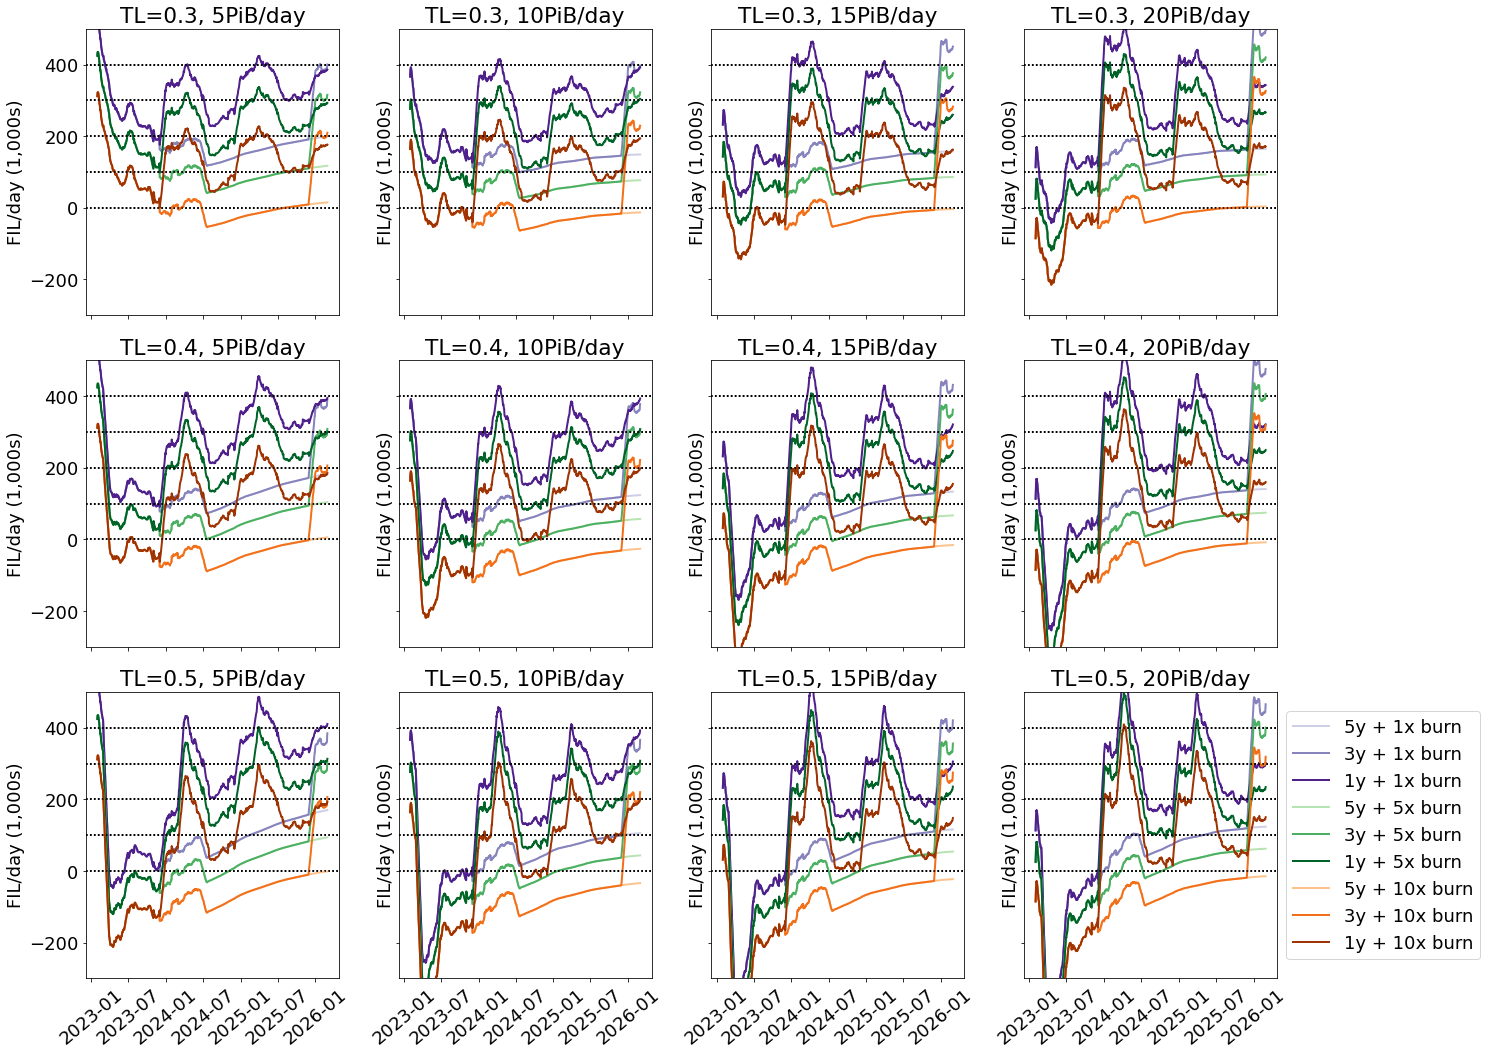

In [36]:
target_locks=[0.3,0.4,0.5]
onboardings=[5,10,15,20]
years=[1,3,5]
burn_boosts=[1,5,10]

colormap_vecs = ['Purples', 'Greens', 'Oranges']
cmap_access_vec = np.linspace(0.3,0.9,len(years))

min_time = datetime.date(2023,1,1)
max_time = datetime.date(2026,3,1)

fig, axes = plt.subplots(nrows=len(target_locks), 
                         ncols=len(onboardings), 
                         figsize=(21,15), 
                         sharex=True, 
                         sharey=True)
for bi, burn_boost in enumerate(burn_boosts):
    cmap = cm.get_cmap(colormap_vecs[bi])
    for ti, target_lock_i in enumerate(target_locks):
        for oi, onboarding_i in enumerate(onboardings):
            ax = axes[ti,oi]
            for yi, yr in enumerate(years[::-1]):
                c = cmap(cmap_access_vec[yi])
                plt_df = duration_loop_results[f'Scenario-2_TargetRBP={onboarding_i}({yr}-Y_{target_lock_i}-LT_{burn_boost}-bb)']['rbp_roi'][['date', 'network_locked', 'circ_supply', 'network_gas_burn', 'total_vest', 'cum_network_reward']]
                plt_df = filter_df_date(plt_df, min_time, max_time)
                plt_df['cum_outflow'] = plt_df['network_gas_burn'] + plt_df['network_locked']
                plt_df['cum_inflow'] = plt_df['total_vest'] + plt_df['cum_network_reward']
                plt_df['cum_netflow'] = plt_df['cum_inflow'] - plt_df['cum_outflow']
                plt_df['netflow'] = plt_df['cum_netflow'].diff()
                ax.plot(plt_df['date'], plt_df['netflow'].rolling(30).mean()/1000, label=f'{yr}y + {burn_boost}x burn', color=c, lw=2)
            ax.axhline(0, linestyle=':', color='k')
            ax.axhline(100, linestyle=':', color='k')
            ax.axhline(200, linestyle=':', color='k')
            ax.axhline(300, linestyle=':', color='k')
            ax.axhline(400, linestyle=':', color='k')
            ax.set_title(f'TL={target_lock_i}, {onboarding_i}PiB/day')
            ax.tick_params(axis='x', labelrotation=40)
            ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
            ax.set_ylabel("FIL/day (1,000s)")
            ax.set_ylim(-300,500)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));
plt.tight_layout();

### 2. Net daily flow
* Across new average durations in {1,3,5}yr
* New target locks in {0.3,0.4,0.5}
* And future burning boosted by {1x,5x,10x}
* **With** SDM applied

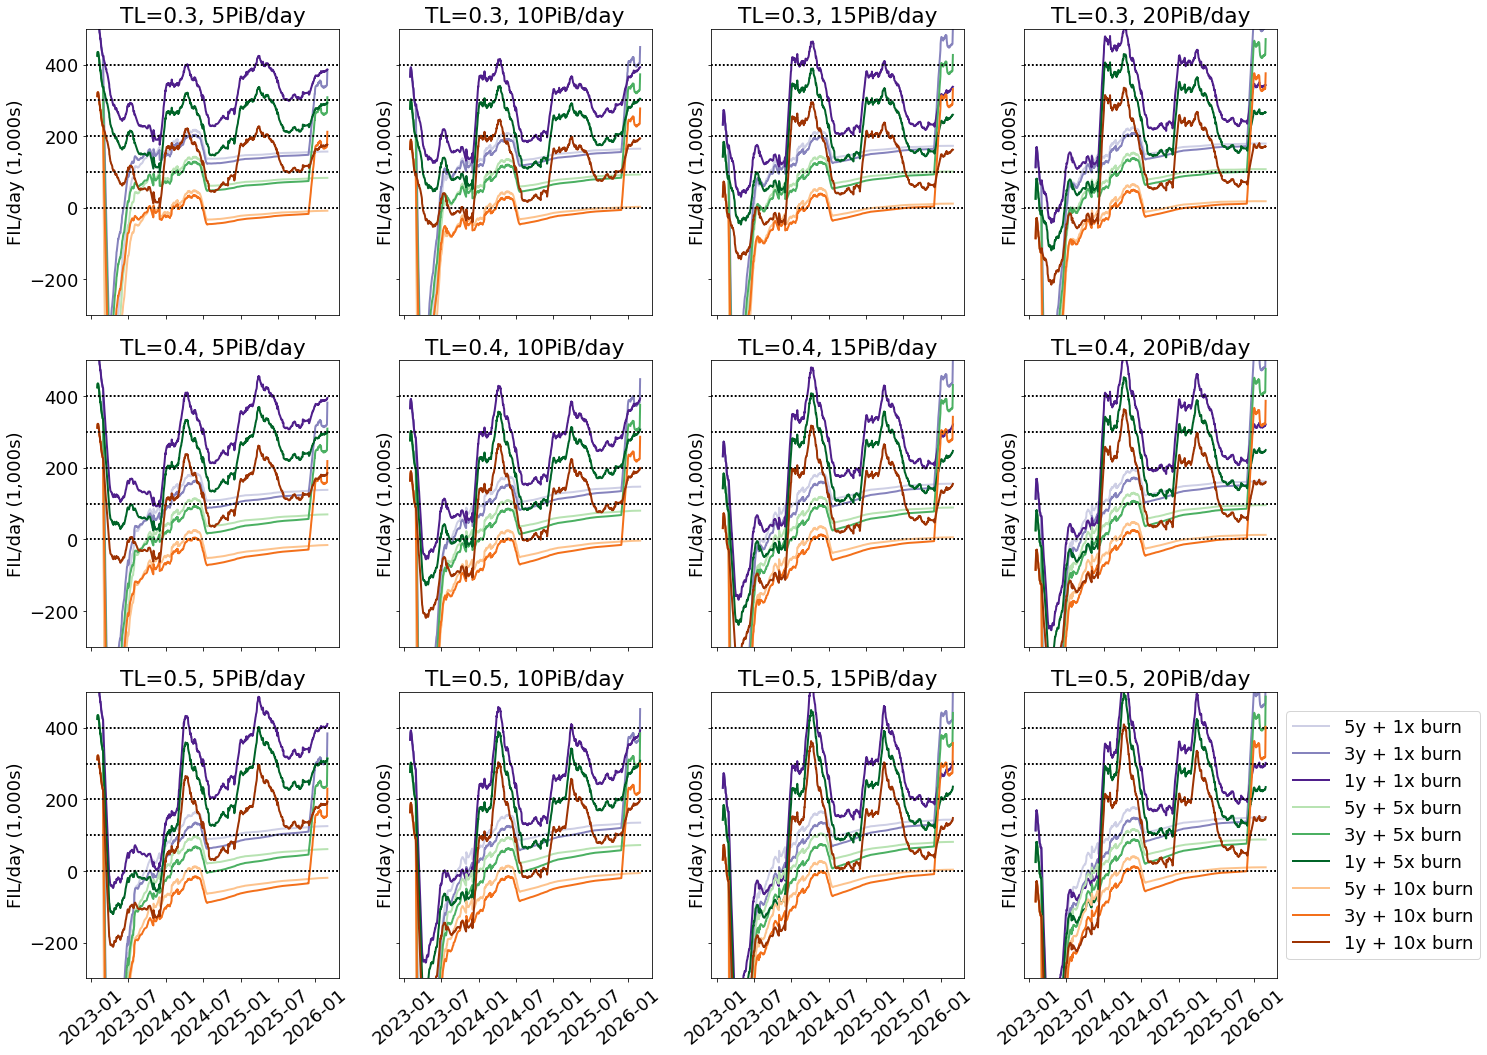

In [37]:
target_locks=[0.3,0.4,0.5]
onboardings=[5,10,15,20]
years=[1,3,5]
burn_boosts=[1,5,10]

colormap_vecs = ['Purples', 'Greens', 'Oranges']
cmap_access_vec = np.linspace(0.3,0.9,len(years))

min_time = datetime.date(2023,1,1)
max_time = datetime.date(2026,3,1)

fig, axes = plt.subplots(nrows=len(target_locks), 
                         ncols=len(onboardings), 
                         figsize=(21,15), 
                         sharex=True, 
                         sharey=True)
for bi, burn_boost in enumerate(burn_boosts):
    cmap = cm.get_cmap(colormap_vecs[bi])
    for ti, target_lock_i in enumerate(target_locks):
        for oi, onboarding_i in enumerate(onboardings):
            ax = axes[ti,oi]
            for yi, yr in enumerate(years[::-1]):
                c = cmap(cmap_access_vec[yi])
                plt_df = duration_loop_results[f'Scenario-3_TargetRBP={onboarding_i}({yr}-Y_{target_lock_i}-LT_{burn_boost}-bb)']['rbp_roi'][['date', 'network_locked', 'circ_supply', 'network_gas_burn', 'total_vest', 'cum_network_reward']]
                plt_df = filter_df_date(plt_df, min_time, max_time)
                plt_df['cum_outflow'] = plt_df['network_gas_burn'] + plt_df['network_locked']
                plt_df['cum_inflow'] = plt_df['total_vest'] + plt_df['cum_network_reward']
                plt_df['cum_netflow'] = plt_df['cum_inflow'] - plt_df['cum_outflow']
                plt_df['netflow'] = plt_df['cum_netflow'].diff()
                ax.plot(plt_df['date'], plt_df['netflow'].rolling(30).mean()/1000, label=f'{yr}y + {burn_boost}x burn', color=c, lw=2)
            ax.axhline(0, linestyle=':', color='k')
            ax.axhline(100, linestyle=':', color='k')
            ax.axhline(200, linestyle=':', color='k')
            ax.axhline(300, linestyle=':', color='k')
            ax.axhline(400, linestyle=':', color='k')
            ax.set_title(f'TL={target_lock_i}, {onboarding_i}PiB/day')
            ax.tick_params(axis='x', labelrotation=40)
            ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
            ax.set_ylabel("FIL/day (1,000s)")
            ax.set_ylim(-300,500)
ax.legend();
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));
plt.tight_layout();

For additional context, the circulating supply is also given in the following two images across the same range of scenarios.

### 1. Projected circulating supply
* Across new average durations in {1,3,5}yr
* New target locks in {0.3,0.4,0.5}
* And future burning boosted by {1x,5x,10x}
* **Without** SDM applied (corresponding to the average duration).

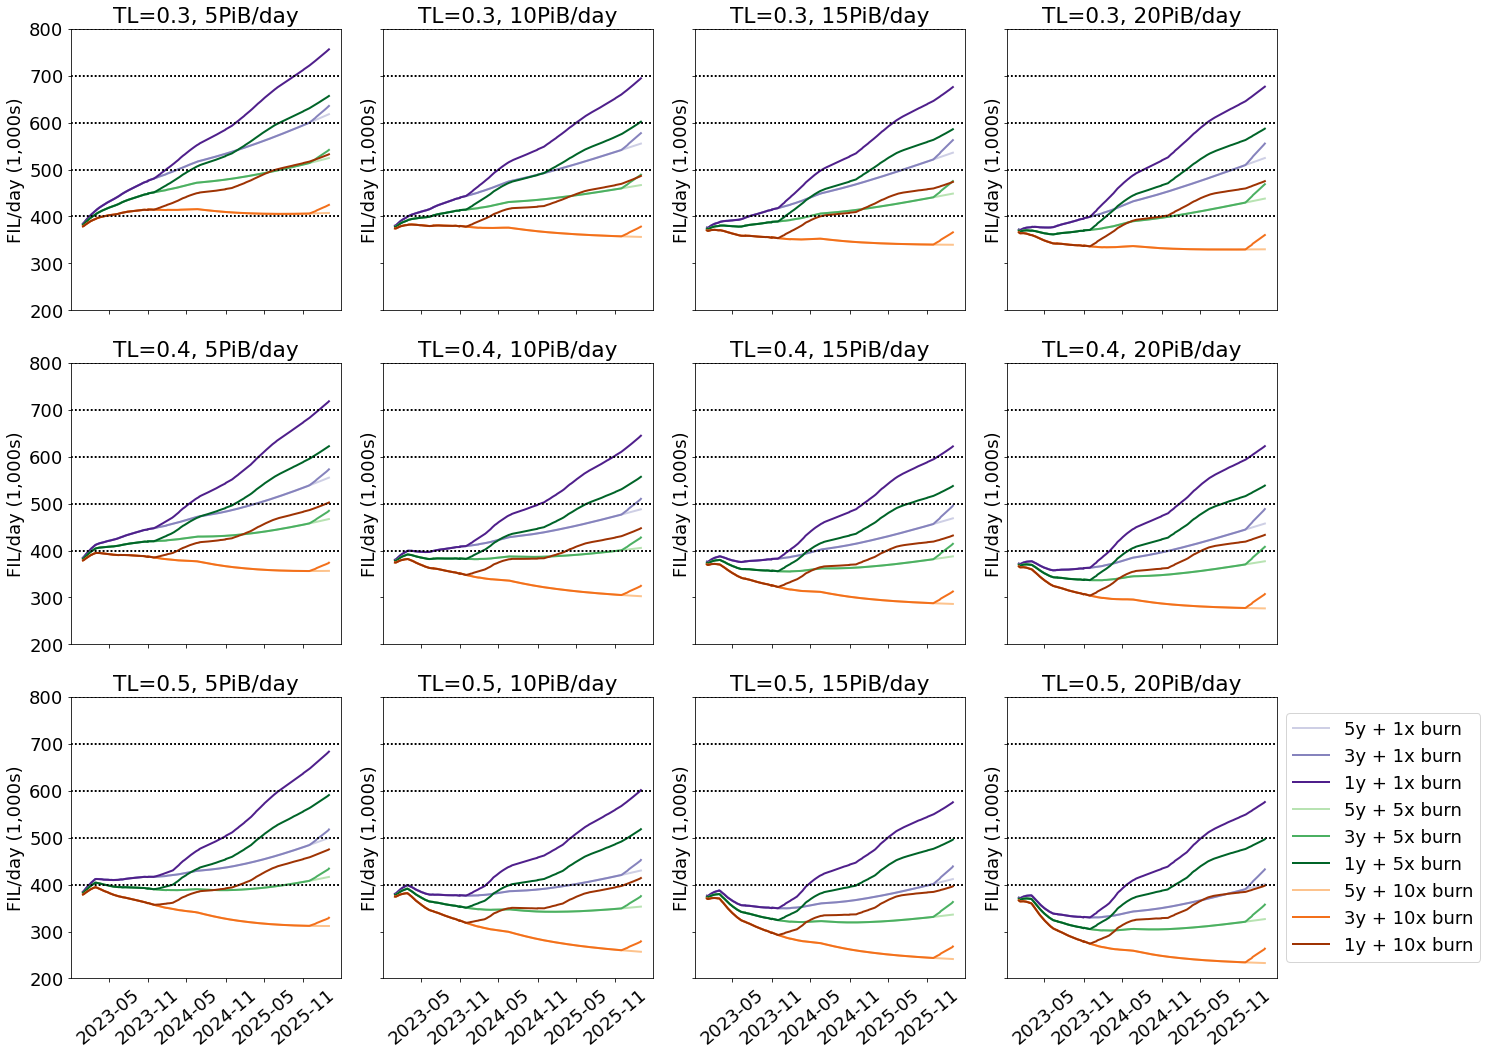

In [38]:
target_locks=[0.3,0.4,0.5]
onboardings=[5,10,15,20]
years=[1,3,5]
burn_boosts=[1,5,10]

colormap_vecs = ['Purples', 'Greens', 'Oranges']
cmap_access_vec = np.linspace(0.3,0.9,len(years))

min_time = datetime.date(2023,1,1)
max_time = datetime.date(2026,3,1)

fig, axes = plt.subplots(nrows=len(target_locks), 
                         ncols=len(onboardings), 
                         figsize=(21,15), 
                         sharex=True, 
                         sharey=True)
for bi, burn_boost in enumerate(burn_boosts):
    cmap = cm.get_cmap(colormap_vecs[bi])
    for ti, target_lock_i in enumerate(target_locks):
        for oi, onboarding_i in enumerate(onboardings):
            ax = axes[ti,oi]
            for yi, yr in enumerate(years[::-1]):
                c = cmap(cmap_access_vec[yi])
                plt_df = duration_loop_results[f'Scenario-2_TargetRBP={onboarding_i}({yr}-Y_{target_lock_i}-LT_{burn_boost}-bb)']['rbp_roi'][['date', 'network_locked', 'circ_supply', 'network_gas_burn', 'total_vest', 'cum_network_reward']]
                plt_df = filter_df_date(plt_df, min_time, max_time)
                plt_df['cum_outflow'] = plt_df['network_gas_burn'] + plt_df['network_locked']
                plt_df['cum_inflow'] = plt_df['total_vest'] + plt_df['cum_network_reward']
                plt_df['cum_netflow'] = plt_df['cum_inflow'] - plt_df['cum_outflow']
                plt_df['netflow'] = plt_df['cum_netflow'].diff()
                ax.plot(plt_df['date'], plt_df['cum_netflow']/MEGA, label=f'{yr}y + {burn_boost}x burn', color=c, lw=2)
            ax.axhline(800, linestyle=':', color='k')
            ax.axhline(700, linestyle=':', color='k')
            ax.axhline(600, linestyle=':', color='k')
            ax.axhline(500, linestyle=':', color='k')
            ax.axhline(400, linestyle=':', color='k')
            ax.set_title(f'TL={target_lock_i}, {onboarding_i}PiB/day')
            ax.tick_params(axis='x', labelrotation=40)
            ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
            ax.set_ylabel("FIL/day (1,000s)")
            ax.set_ylim(200,800)
ax.legend();
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));
plt.tight_layout();

### 2. Projected circulating supply
* Across new average durations in {1,3,5}yr
* New target locks in {0.3,0.4,0.5}
* And future burning boosted by {1x,5x,10x}
* **With** SDM applied

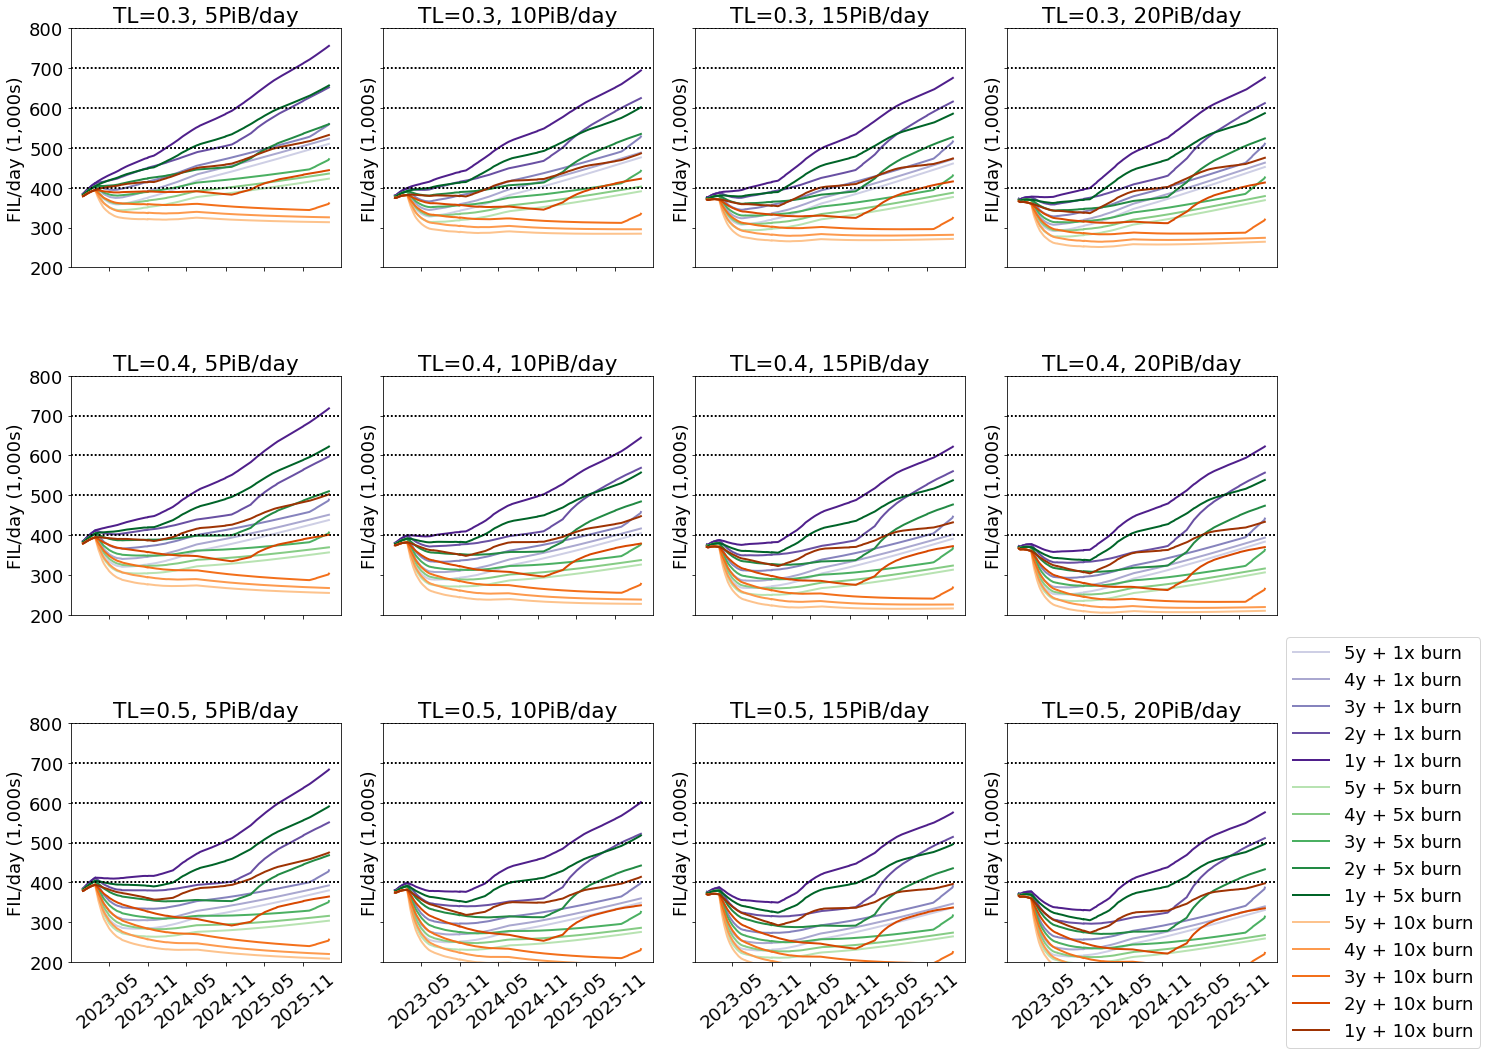

In [41]:
target_locks=[0.3,0.4,0.5]
onboardings=[5,10,15,20]
years=[1,2,3,4,5]
burn_boosts=[1,5,10]

colormap_vecs = ['Purples', 'Greens', 'Oranges']
cmap_access_vec = np.linspace(0.3,0.9,len(years))

min_time = datetime.date(2023,1,1)
max_time = datetime.date(2026,3,1)

fig, axes = plt.subplots(nrows=len(target_locks), 
                         ncols=len(onboardings), 
                         figsize=(21,15), 
                         sharex=True, 
                         sharey=True)
for bi, burn_boost in enumerate(burn_boosts):
    cmap = cm.get_cmap(colormap_vecs[bi])
    for ti, target_lock_i in enumerate(target_locks):
        for oi, onboarding_i in enumerate(onboardings):
            ax = axes[ti,oi]
            for yi, yr in enumerate(years[::-1]):
                c = cmap(cmap_access_vec[yi])
                plt_df = duration_loop_results[f'Scenario-3_TargetRBP={onboarding_i}({yr}-Y_{target_lock_i}-LT_{burn_boost}-bb)']['rbp_roi'][['date', 'network_locked', 'circ_supply', 'network_gas_burn', 'total_vest', 'cum_network_reward']]
                plt_df = filter_df_date(plt_df, min_time, max_time)
                plt_df['cum_outflow'] = plt_df['network_gas_burn'] + plt_df['network_locked']
                plt_df['cum_inflow'] = plt_df['total_vest'] + plt_df['cum_network_reward']
                plt_df['cum_netflow'] = plt_df['cum_inflow'] - plt_df['cum_outflow']
                plt_df['netflow'] = plt_df['cum_netflow'].diff()
                ax.plot(plt_df['date'], plt_df['cum_netflow']/MEGA, label=f'{yr}y + {burn_boost}x burn', color=c, lw=2)
            ax.axhline(800, linestyle=':', color='k')
            ax.axhline(700, linestyle=':', color='k')
            ax.axhline(600, linestyle=':', color='k')
            ax.axhline(500, linestyle=':', color='k')
            ax.axhline(400, linestyle=':', color='k')
            ax.set_title(f'TL={target_lock_i}, {onboarding_i}PiB/day')
            ax.tick_params(axis='x', labelrotation=40)
            ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
            ax.set_ylabel("FIL/day (1,000s)")
            ax.set_ylim(200,800)
ax.legend();
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));
plt.tight_layout();